In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import time
import faiss
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
wendy_data_directory = '/users/Wendy/Capstone/saudi_arabia_112019_tweets_csv_hashed_1.csv'
gefei_data_directory = '/Users/Sylvia/Desktop/1006/saudi_arabia_112019_tweets_csv_hashed/saudi_arabia_112019_tweets_csv_hashed_1.csv'
tweets = pd.read_csv(gefei_data_directory)

/Users/Sylvia/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3203: DtypeWarning: Columns (15,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
import re

def remove_tags_and_links(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    return text

tweets['cleaned_text'] = tweets['tweet_text'].apply(remove_tags_and_links)

## faiss

What method does faiss indexing use for clustering?  
__Hierarchical Clustering on Quantized Vectors (HCQ)__  
1. Vector Quantization: Faiss first quantizes the vectors in your dataset into a codebook of centroids. This step reduces the dimensionality of the data and speeds up search operations.
2. Hierarchical Structure: HCQ builds a hierarchical structure by grouping these centroids into clusters recursively. It creates a tree-like structure where each node represents a cluster of centroids.
3. Search and Clustering: This hierarchical structure can be used to perform approximate nearest neighbor search with the advantage that you can trade off accuracy for speed by selecting different levels of the tree. It can also be used for clustering by selecting subsets of the tree or specific clusters at various levels.

__Difference between KNN and faiss:__
1. Faiss is specifically designed for efficient similarity search and indexing. Its primary purpose is to accelerate nearest neighbor search in high-dimensional spaces.
2. Faiss is highly optimized for efficient similarity search. It uses techniques like vector quantization and hierarchical structures to speed up nearest neighbor search in high-dimensional spaces.
3. Traditional KNN typically doesn't use indexing structures. It performs a brute-force search by computing distances for all data points.

### 500 english tweets

In [6]:
sample_tweets_english = tweets[(tweets['tweet_language'] == 'en') & (tweets['is_retweet']==False)]['cleaned_text'][:500]
sample_tweets_english=sample_tweets_english.tolist()
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
start_time = time.time()
embeddings_english = model.encode(list(sample_tweets_english), convert_to_tensor=True)
end_time = time.time()
print("MiniLM Embedding Time for 500 Tweets: {}".format(end_time-start_time))



MiniLM Embedding Time for 500 Tweets: 10.688636779785156


In [7]:
embed_dimension = embeddings_english.shape[1]
nlist = 10  # number of clusters
quantiser = faiss.IndexFlatL2(embed_dimension)  # flat indexing
index = faiss.IndexIVFFlat(quantiser, embed_dimension, nlist, faiss.METRIC_L2)

In [8]:
index.train(embeddings_english)  # train on the database vectors
print(index.ntotal)   # 0
index.add(embeddings_english)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

0
True
500


In [9]:
nprobe = 2  # find nprobe most similar clusters
k = 2  # return k nearest neighbours

distances, indices = index.search(embeddings_english, k)

In [10]:
similar_tweets = []
for i, j in indices: similar_tweets.append([[sample_tweets_english[i]],[sample_tweets_english[j]]])

In [11]:
simiar_check = pd.DataFrame(similar_tweets)
simiar_check['distance'] = distances[:,1]
simiar_check[simiar_check['distance']>3].sort_values(by='distance')

,0,1,distance
433,[n i n e♥️],[Ander 💔💔 ],3.691048
19,[Ander 💔💔 ],[n i n e♥️],3.691048
12,[My instagram 🦋🦋 ],[Ander 💔💔 ],4.632502
266,"[ Iran is the dangerous country in the world, ...",[ The Iranian regime has attacked today two sh...,4.658755
472,[ The Iranian regime has attacked today two sh...,"[ Iran is the dangerous country in the world, ...",4.658755
...,...,...,...
38,[My favorite car#girlsnight ],[ Great Night 🔥🔥🔥🔥🔥😍],31.434664
101,[goddess ],[ beautiful thing],31.659117
7,[#تتزوج_جنوبيه_ولا_مغربيه\n💜aA\nMusic Atlas of...,[ I would love to remember all the amazing thi...,33.646252
458,[ GTA San Andreas],"[ In the day of the fight, I will be there wat...",34.454895


### 5000 tweets

In [12]:
model_MiniLM = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
start_time = time.time()
sample_tweets_5000 = tweets[:5000]['cleaned_text']
embeddings_5000 = model.encode(list(sample_tweets_5000), convert_to_tensor=True)
end_time = time.time()
print("MiniLM Embedding Time for 5000 Tweets: {}".format(end_time-start_time))

MiniLM Embedding Time for 5000 Tweets: 233.31651210784912


In [13]:
embed_dimension = embeddings_5000.shape[1]
nlist = 10  # number of clusters
quantiser = faiss.IndexFlatL2(embed_dimension)  # flat indexing
index = faiss.IndexIVFFlat(quantiser, embed_dimension, nlist, faiss.METRIC_L2)

In [14]:
index.train(embeddings_5000)  # train on the database vectors

index.add(embeddings_5000)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

True
5000


In [15]:
nprobe = 2  # find 2 most similar clusters
k = 2  # return 2 nearest neighbours

distances, indices = index.search(embeddings_5000, k)

In [16]:
similar_tweets = []
for i, j in indices: similar_tweets.append([[sample_tweets_5000[i]],[sample_tweets_5000[j]]])
simiar_check_5000 = pd.DataFrame(similar_tweets)
simiar_check_5000['distance'] = distances[:,1]
simiar_check_5000=simiar_check_5000.sort_values(by='distance')
simiar_check_5000[simiar_check_5000['distance']>3]

,0,1,distance
968,[بيندمون عليها النصراويين],[#قيلوله ],3.001082
1745,[RT : لا شَيء ف الحياة أروع \nمن قلب يدعو لك و...,[RT : لا تجري ورا شخص عشان يهتم فيك لا تعاتبه ...,3.005398
2238,[RT : ساعة فرزاتشي 11\nالتوصيل خلال ساعة دا...,[RT : ساعة فرزاتشي رجالي\n\nالتوصيل خلال ساعه...,3.006899
4177,[هذا اللي رايح بنك سامبا ياخذ غرض لموسم الرياض ],[#الاسراء_والمعراج\n💜 ],3.007576
3663,[ضمك بيديور على الدرجة الاولى اذا هذا مستواهم],[محظور مايمدينن انقط😔],3.007753
...,...,...,...
4046,[A Modeling Problem is a bug that reveals a fu...,[الظروف الراهنه ماهوب ناقصها معاتب خلني لين ات...,16.689297
3595,[The first principle of software engineering i...,[بلا فلسفه ياسولشاير والعب بخطة منطقيه],16.867218
3138,[#تتزوج_جنوبيه_ولا_مغربيه\n💜aA\nMusic Atlas of...,[حان الآن أذان المغرب لمدينة #الرياض 6:08\n\n],17.891151
3315,"[""Programs that write programs are the happies...",[خلصوا فرحة ذوليك ولا للحين؟],19.223919


## How to use faiss to do clustering?

__Need to try different indexing methods on our data:__  
IndexFlatL2: Performs exact L2 (Euclidean) distance search,   
IndexFlatIP: Performs exact inner product (cosine similarity) search.

IndexIVFFlat: Uses an inverted file for indexing. It's efficient for large-scale datasets and supports both L2 and inner product search.
IndexIVFPQ: Combines inverted files with product quantization (PQ) for improved memory efficiency and speed in high-dimensional spaces.  
 and etc.

### Clustering with flat indexing

In [17]:
embeddings_arr = np.array(embeddings_english)

In [18]:
start_time = time.time()
num_tweets, embedding_dim = embeddings_arr.shape


# Normalize embeddings
faiss.normalize_L2(embeddings_arr)


num_clusters = 5 #TODO: find K

# Initialize k-means clustering index
kmeans = faiss.Kmeans(embedding_dim, num_clusters, niter=100, verbose=True)


kmeans.train(embeddings_arr)

_, cluster_indices = kmeans.index.search(embeddings_arr, 1) # Assign each tweet to a cluster

end_time = time.time()
print("Clustering without indexing time for 500 Tweets: {}".format(end_time-start_time))

# Create a dictionary for each cluster
cluster_to_tweets = {cluster_id: [] for cluster_id in range(num_clusters)}

# Get the tweet content
tweets_content = [ sample_tweets_english[i] for i in range(num_tweets) ]


for tweet_idx, cluster_id in enumerate(cluster_indices):
    cluster_to_tweets[cluster_id[0]].append(tweets_content[tweet_idx])

cluster_data = []
for cluster_id, twe in cluster_to_tweets.items():
    for tweet in twe:
        cluster_data.append([cluster_id, tweet])


clusters= pd.DataFrame(cluster_data, columns=["Cluster", "Tweet"])

clusters


Clustering 500 points in 384D to 5 clusters, redo 1 times, 100 iterations
  Preprocessing in 0.00 s
Clustering without indexing time for 500 Tweets: 0.23326897621154785


,Cluster,Tweet
0,0,My favorite car#girlsnight
1,0,wow twins omg!!!!!
2,0,🎙: I'm the best in the world \n\n- 🎙:\n\n#FI...
3,0,The Best FIFA Football Awards 2019 - Marcelo.
4,0,The Best FIFA Football Awards 2019 - Eden Haza...
...,...,...
495,4,They will do anything to make the region unst...
496,4,YESSS!!\nI don't know why they attacking us! ...
497,4,Iran does only understand the language of war...
498,4,"After the ships attack, the international tra..."


### Try alternative indexing methods

In [33]:
num_tweets, embedding_dim = embeddings_arr.shape
results = {}
K = 5
num_clusters = K
indexing_methods = [
    faiss.IndexFlatL2(embedding_dim),
    faiss.IndexFlatIP(embedding_dim),
    faiss.IndexIVFFlat(faiss.IndexFlatL2(embedding_dim), embedding_dim, num_clusters, faiss.METRIC_L2),
    faiss.IndexHNSWFlat(embedding_dim, num_clusters),  # HNSW index
    faiss.IndexLSH(embedding_dim, num_clusters),  # LSH index
    faiss.IndexScalarQuantizer(embedding_dim, faiss.ScalarQuantizer.QT_8bit),  # Scalar quantizer
]



for index_method in indexing_methods:
    start_time = time.time()
    faiss.normalize_L2(embeddings_arr)

    # Initialize a K-Means index in Faiss
    index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance)

    # Train the K-Means model
    kmeans = faiss.Kmeans(embedding_dim, K)

    kmeans.index = index_method


    kmeans.train(embeddings_arr)  # You can optionally retrain the model

    # Perform clustering
    _, cluster_indices = kmeans.index.search(embeddings_arr, 1)  # Assign each point to the nearest cluster

    end_time = time.time()
    print("Clustering with indexing time for 500 Tweets: {}".format(end_time-start_time))
    
    results[str(index_method)] = {
        "clustering_time": end_time - start_time}
results


Clustering with indexing time for 500 Tweets: 0.05022406578063965
Clustering with indexing time for 500 Tweets: 0.020138978958129883
Clustering with indexing time for 500 Tweets: 0.019218921661376953
Clustering with indexing time for 500 Tweets: 0.01678013801574707
Clustering with indexing time for 500 Tweets: 0.017792940139770508
Clustering with indexing time for 500 Tweets: 0.01789116859436035


{"<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f876b921bd0> >": {'clustering_time': 0.05022406578063965},
 "<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f876b921c90> >": {'clustering_time': 0.020138978958129883},
 "<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7f876b9210f0> >": {'clustering_time': 0.019218921661376953},
 "<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7f876b45c6f0> >": {'clustering_time': 0.01678013801574707},
 "<faiss.swigfaiss_avx2.IndexLSH; proxy of <Swig Object of type 'faiss::IndexLSH *' at 0x7f879ee513f0> >": {'clustering_time': 0.017792940139770508},
 "<faiss.swigfaiss_avx2.IndexScalarQuantizer; proxy of <Swig Object of type 'faiss::IndexScalarQuantizer *' at 0x7f879ee9af00> >": {'clustering_time': 0.01789116859436035}}

### Use 5000 tweets

#### With flat indexing

In [34]:
embeddings_arr_5000 = np.array(embeddings_5000)

In [35]:
start_time = time.time()
K = 5
num_tweets, embedding_dim = embeddings_arr_5000.shape
faiss.normalize_L2(embeddings_arr_5000)

# Initialize a K-Means index in Faiss
# index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance)

# Train the K-Means model
kmeans = faiss.Kmeans(embedding_dim, K)

kmeans.train(embeddings_arr_5000)
# Perform clustering
_, cluster_indices = kmeans.index.search(embeddings_arr_5000, 1)  # Assign each point to the nearest cluster
end_time = time.time()
print("Clustering without indexing time for 5000 Tweets: {}".format(end_time-start_time))


cluster_to_tweets = {cluster_id: [] for cluster_id in range(num_clusters)}

tweets_content = [ sample_tweets_5000[i] for i in range(num_tweets) ]


for tweet_idx, cluster_id in enumerate(cluster_indices):
    cluster_to_tweets[cluster_id[0]].append(tweets_content[tweet_idx])

cluster_data = []
for cluster_id, twe in cluster_to_tweets.items():
    for tweet in twe:
        cluster_data.append([cluster_id, tweet])


clusters= pd.DataFrame(cluster_data, columns=["Cluster", "Tweet"])

clusters

Clustering without indexing time for 5000 Tweets: 0.06995820999145508


,Cluster,Tweet
0,0,(للرجال نصيب مما ترك الوالدان والأقربون وللنسا...
1,0,(من كان يريد حرث الآخرة نزد له في حرثه ومن كان...
2,0,سويت كل شي ياماتيتش 💔
3,0,جوفينكو وش قاعد يسوي!!
4,0,#اكتب_بيت_شعر_تحبه\n💜aA
...,...,...
4995,4,ساعة صمارينر اوتوماتيك\n\nالتوصيل خلال ساعه ا...
4996,4,ساعة رولكس اوتوماتيك \n\nالتوصيل خلال ساعه الر...
4997,4,ساعة هوبلو جديد نسائيه\n\nالتوصيل خلال ساعه ال...
4998,4,#كم_ساعه_تقضيها_بالنت_يوميا\nلا وشحنه يقعد 66 ...


### Time spent on different indexing methods

In [41]:
num_tweets, embedding_dim = embeddings_arr_5000.shape
results = {}
K = 5
num_clusters = K
indexing_methods = [
    faiss.IndexFlatL2(embedding_dim),
    faiss.IndexFlatIP(embedding_dim),
    faiss.IndexIVFFlat(faiss.IndexFlatL2(embedding_dim), embedding_dim, num_clusters, faiss.METRIC_L2),
    faiss.IndexHNSWFlat(embedding_dim, num_clusters),  # HNSW index
    faiss.IndexLSH(embedding_dim, num_clusters),  # LSH index
    faiss.IndexScalarQuantizer(embedding_dim, faiss.ScalarQuantizer.QT_8bit),  # Scalar quantizer
]



for index_method in indexing_methods:
    start_time = time.time()
    faiss.normalize_L2(embeddings_arr_5000)

    # Initialize a K-Means index in Faiss
    index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance)

    # Train the K-Means model
    kmeans = faiss.Kmeans(embedding_dim, K)

    kmeans.index = index_method


    kmeans.train(embeddings_arr_5000)  # You can optionally retrain the model

    # Perform clustering
    _, cluster_indices = kmeans.index.search(embeddings_arr_5000, 1)  # Assign each point to the nearest cluster

    end_time = time.time()
    print("Clustering with indexing time for 500 Tweets: {}".format(end_time-start_time))
    
    results[str(index_method)] = {
        "clustering_time": end_time - start_time}
results


Clustering with indexing time for 500 Tweets: 0.07226800918579102
Clustering with indexing time for 500 Tweets: 0.045885324478149414
Clustering with indexing time for 500 Tweets: 0.06001091003417969
Clustering with indexing time for 500 Tweets: 0.0630950927734375
Clustering with indexing time for 500 Tweets: 0.0751950740814209
Clustering with indexing time for 500 Tweets: 0.1025547981262207


{"<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f876b94a330> >": {'clustering_time': 0.07226800918579102},
 "<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f876bcebb40> >": {'clustering_time': 0.045885324478149414},
 "<faiss.swigfaiss_avx2.IndexIVFFlat; proxy of <Swig Object of type 'faiss::IndexIVFFlat *' at 0x7f876bceb8d0> >": {'clustering_time': 0.06001091003417969},
 "<faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7f876bceb690> >": {'clustering_time': 0.0630950927734375},
 "<faiss.swigfaiss_avx2.IndexLSH; proxy of <Swig Object of type 'faiss::IndexLSH *' at 0x7f87d90d9f00> >": {'clustering_time': 0.0751950740814209},
 "<faiss.swigfaiss_avx2.IndexScalarQuantizer; proxy of <Swig Object of type 'faiss::IndexScalarQuantizer *' at 0x7f87b81d1810> >": {'clustering_time': 0.1025547981262207}}

## Other clustering method? agglomerative clustering

In [42]:
faiss.Clustering(embedding_dim,5)

<faiss.swigfaiss_avx2.Clustering; proxy of <Swig Object of type 'faiss::Clustering *' at 0x7f88dfae9690> >

In [55]:
num_tweets, embedding_dim = embeddings_arr_5000.shape
faiss.normalize_L2(embeddings_arr)

num_clusters = 5 

# Initialize agglomerative clustering index

clustering = faiss.Clustering(embedding_dim, num_clusters)

index = faiss.IndexFlatL2(embedding_dim)
clustering.clus_index = index

clustering.niter = 50

# Train the agglomerative clustering model
clustering.verbose = True  # Enable verbose output for training
clustering.train(embeddings_arr_5000, index)

_, labels = index.search(embeddings_arr_5000, 1)


cluster_to_tweets = {cluster_id: [] for cluster_id in range(num_clusters)}

tweets_content = [ sample_tweets_5000[i] for i in range(num_tweets) ]


for tweet_idx, cluster_id in enumerate(labels):
    cluster_to_tweets[cluster_id[0]].append(tweets_content[tweet_idx])

cluster_data = []
for cluster_id, twe in cluster_to_tweets.items():
    for tweet in twe:
        cluster_data.append([cluster_id, tweet])


clusters= pd.DataFrame(cluster_data, columns=["Cluster", "Tweet"])

clusters



Sampling a subset of 1280 / 5000 for training
Clustering 1280 points in 384D to 5 clusters, redo 1 times, 50 iterations
  Preprocessing in 0.00 s


,Cluster,Tweet
0,0,(للرجال نصيب مما ترك الوالدان والأقربون وللنسا...
1,0,(من كان يريد حرث الآخرة نزد له في حرثه ومن كان...
2,0,سويت كل شي ياماتيتش 💔
3,0,جوفينكو وش قاعد يسوي!!
4,0,#اكتب_بيت_شعر_تحبه\n💜aA
...,...,...
4995,4,ساعة صمارينر اوتوماتيك\n\nالتوصيل خلال ساعه ا...
4996,4,ساعة رولكس اوتوماتيك \n\nالتوصيل خلال ساعه الر...
4997,4,ساعة هوبلو جديد نسائيه\n\nالتوصيل خلال ساعه ال...
4998,4,#كم_ساعه_تقضيها_بالنت_يوميا\nلا وشحنه يقعد 66 ...


### Find the optimal number of clusters uing Elbow method

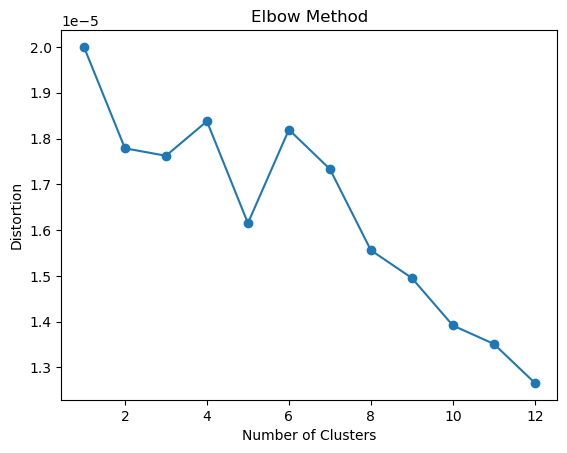

In [38]:
num_tweets, embedding_dim = embeddings_arr.shape


# Normalize embeddings
faiss.normalize_L2(embeddings_arr)

distortions = []

max_clusters = 12

for num_clusters in range(1, max_clusters + 1):

    kmeans = faiss.Kmeans(embedding_dim, num_clusters, niter=100, verbose=False)
    kmeans.train(embeddings_arr)
    
    # Assign each tweet to a cluster
    _, cluster_indices = kmeans.index.search(embeddings_arr, 1)  
    
    # Compute the distortion (sum of squared distances) for this number of clusters
    distortion = np.sum(np.min(np.square(embeddings_arr - kmeans.centroids[cluster_indices[:, 0]]), axis=1))
#     print(kmeans.centroids[cluster_indices[:, 0]].shape,embeddings_arr.shape)
    
    distortions.append(distortion)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()
# print(distortions)

In [39]:
# TODO: train test split